In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from pymorphy2 import MorphAnalyzer
from nltk import regexp_tokenize, download
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, Dense, TextVectorization, Input, Dropout, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.utils import to_categorical

import pickle
import numpy

In [10]:
data = pd.read_csv('users.csv')
X = data.user_data
y = data.mapping
NUM_OF_CLASSES = len(y.unique())

In [12]:
X[0]

'Биология, физика, КИНО, книги, музыка, настолки, игры,Учёба, физика, лыцалство,S (95 МэВ/с^2, - 1/3, 1/2),Ведьмак, Белая Гвардия, Мастер и Маргарита, Швейк, Метро,Все Мстители, Властелин кольцы и Хоббиты, конечно, Звёздные воины и тд,Scooter: "How much is the fish"Sabaton,научные мемы,Red Head Sound — Перевод и Озвучивание,Замедленная съемка | Gif,шлакоблокунь и друзья,Античненько,Первая мировая война,Типичный Властелин Колец l Трилогия "Хоббит",QuestGuru СПб| Квесты в Санкт-Петербурге,Упоротое Средиземье lСериал Кольца Властиl,СССР - Вспомним всё,ГБОУ школа № 62 Выборгского района СПб,Санкт-Петербургский Океанариум,историчненько,Типичный Ведьмак,Знакомо?,Юмор Шрёдингера,СТФ,StarCraft Memes «Прокси барак»,Секта Свидетелей Коммунизма,Типичный Ведьмак,Первобытные мемы,Скриншоты, которые мы заслужили,Олимпиады, ЕГЭ, ОГЭ по математике | Борис Трушин,РИМСКАЯ ИМПЕРИЯ | SPQR,Музеи Питера,StarCraft 2 League,Чайная Айро | Аватар Мемы,Kuplinov ► Play,DigitalRazor,История России для "чайников",Ш

In [3]:
y = to_categorical(y, num_classes=NUM_OF_CLASSES)

In [4]:
download('stopwords')
stops = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zayse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form if tok not in stops else ''
            for tok in regexp_tokenize(sent, pat)]


X = X.map(lambda x: " ".join(normalize(x)))

In [14]:
X[0]

'биология физика кино книга музыка настолочь игра учёба физика лыцалство 95 мэв ведьмак белый гвардия мастер маргарита швейк метро всё мститель властелин колец хоббит  звёздный воин тд scooter how much is the fish sabaton научный мем red head sound перевод озвучивание замедлить съёмка gif шлакоблокунь друг античненький первый мировой война типичный властелин кольцо трилогия хоббит questguru спб квест санкт петербург упороть средиземье lсериал кольцо властиl ссср вспомнить всё гбоу школа 62 выборгский район спб санкт петербургский океанариум историчненький типичный ведьмак знакомый юмор шрёдингер стф starcraft memes проксить барак секта свидетель коммунизм типичный ведьмак первобытный мем скриншот который  заслужить олимпиада егэ огэ  математика борис трушин римский империя spqr музей питер starcraft league чайный айро аватар мем kuplinov play digitalrazor история россия  чайник школа 62 выборгский район санкт петербург записка цицерон физика мем сие самогон сварить анимешница цитата аф

In [6]:
max_words = 0
for desc in X:
    words = len(desc.split())
    if words > max_words:
        max_words = words

In [7]:
all_count_of_words = 10000
tokenizer = Tokenizer(num_words = all_count_of_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [135]:
stats = pd.DataFrame(tokenizer.sequences_to_matrix(X, mode='count'))
stats['class'] = data.mapping
stats.to_csv('stats.csv')

In [37]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
X_LSTM = numpy.array([[k / all_count_of_words for k in x] + [0 for j in range(max_words - len(x))] for x in X])
X_MLP = tokenizer.sequences_to_matrix(X, mode='binary')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_MLP, y, test_size=0.33, random_state=42)

In [12]:
model_MLP = Sequential()
model_MLP.add(Dense(512, input_shape=(all_count_of_words,)))
model_MLP.add(Activation('relu'))
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(NUM_OF_CLASSES))
model_MLP.add(Activation('softmax'))

model_MLP.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_MLP.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                                 
Total params: 5,122,564
Trainable params: 5,122,564
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
batch_size = 32
epochs = 10

history = model_MLP.fit(X_train, y_train,
                    validation_data= (X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
62/62 [==============================] - 3s 45ms/step - loss: 0.6768 - accuracy: 0.7757 - val_loss: 0.5173 - val_accuracy: 0.8364
Epoch 2/10
62/62 [==============================] - 3s 44ms/step - loss: 0.1915 - accuracy: 0.9531 - val_loss: 0.5665 - val_accuracy: 0.8333
Epoch 3/10
62/62 [==============================] - 3s 42ms/step - loss: 0.1253 - accuracy: 0.9677 - val_loss: 0.8025 - val_accuracy: 0.8129
Epoch 4/10
62/62 [==============================] - 3s 44ms/step - loss: 0.1441 - accuracy: 0.9672 - val_loss: 0.6158 - val_accuracy: 0.8436
Epoch 5/10
62/62 [==============================] - 3s 42ms/step - loss: 0.1433 - accuracy: 0.9647 - val_loss: 0.7332 - val_accuracy: 0.8272
Epoch 6/10
62/62 [==============================] - 3s 43ms/step - loss: 0.1444 - accuracy: 0.9642 - val_loss: 0.7687 - val_accuracy: 0.8333
Epoch 7/10
62/62 [==============================] - 2s 40ms/step - loss: 0.1451 - accuracy: 0.9637 - val_loss: 0.7139 - val_accuracy: 0.8231
Epoch 8/10
62

In [14]:
score = model_MLP.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

31/31 [==============================] - 0s 8ms/step - loss: 0.6782 - accuracy: 0.8415
Оценка теста: 0.6782447695732117
Оценка точности модели: 0.8415132761001587


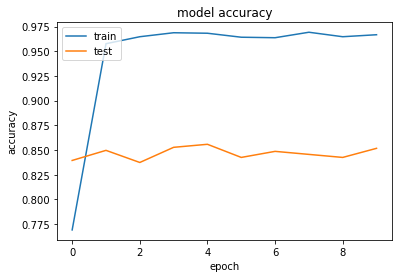

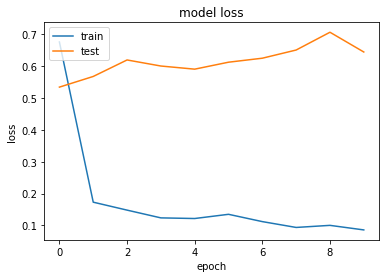

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model_MLP.save('MLP.h5')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_LSTM, y, test_size=0.33, random_state=42)

In [25]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_words, max_words))
#model_LSTM.add(Input(shape=(max_words,)))
model_LSTM.add(LSTM(16,  dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(NUM_OF_CLASSES, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_LSTM.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 695)         483025    
                                                                 
 lstm_6 (LSTM)               (None, 16)                45568     
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 528,661
Trainable params: 528,661
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
batch_size = 32
epochs = 10

history = model_LSTM.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/10
62/62 [==============================] - 15106s 245s/step - loss: 0.5035 - accuracy: 0.4239 - val_loss: 0.4716 - val_accuracy: 0.4090
Epoch 2/10
62/62 [==============================] - 14648s 237s/step - loss: 0.4670 - accuracy: 0.4284 - val_loss: 0.4699 - val_accuracy: 0.4049
Epoch 3/10
62/62 [==============================] - 15792s 255s/step - loss: 0.4653 - accuracy: 0.4345 - val_loss: 0.4697 - val_accuracy: 0.4049
Epoch 4/10
31/62 [==============>...............] - ETA: 2:12:58 - loss: 0.4691 - accuracy: 0.4103

KeyboardInterrupt: 

In [40]:
score = model_LSTM.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

31/31 [==============================] - 1s 45ms/step - loss: 0.4696 - accuracy: 0.4039

Оценка теста: 0.4696057140827179
Оценка точности модели: 0.40388548374176025


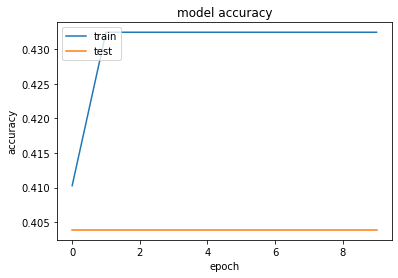

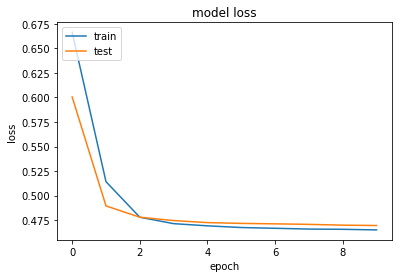

In [41]:
# График точности модели
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# График оценки loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_LSTM.save('LSTM.h5')